# Pytorch example1: Layers of CNN

This tutorial will introduce the basic math operations for general CNN architecture with Pytorch. We will give you some examples. 

Sam, Liu

### `torch.nn` & `torch.optim`

### torch.nn

Neural networks can be constructed using the `torch.nn` package.

Provides pretty much all neural network related functionalities such as :

1. Linear layers - `nn.Linear`, `nn.Bilinear`
2. Convolution Layers - `nn.Conv1d`, `nn.Conv2d`, `nn.Conv3d`, `nn.ConvTranspose2d`
3. Nonlinearities - `nn.Sigmoid`, `nn.Tanh`, `nn.ReLU`, `nn.LeakyReLU`
4. Pooling Layers - `nn.MaxPool1d`, `nn.AveragePool2d`
4. Recurrent Networks - `nn.LSTM`, `nn.GRU`
5. Normalization - `nn.BatchNorm2d`
6. Dropout - `nn.Dropout`, `nn.Dropout2d`
7. Embedding - `nn.Embedding`
8. Loss Functions - `nn.MSELoss`, `nn.CrossEntropyLoss`, `nn.NLLLoss`

Instances of these classes will have an `__call__` function built-in that can be used to run an input through the layer.

### torch.optim
``torch.optim`` is a package implementing various optimization algorithms. Most commonly used methods are already supported, and the interface is general enough, so that more sophisticated ones can be also easily integrated in the future.

To use ``torch.optim`` you have to construct an optimizer object, that will hold the current state and will update the parameters based on the computed gradients.

- torch.optim.SGD()
- torch.optim.Adagrad()
- torch.optim.Adam()
- torch.optim.RMSprop()

```python

optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
optimizer = optim.Adam([var1, var2], lr = 0.0001)
```

#### Taking an optimization step
All optimizers implement a step() method, that updates the parameters. It can be used in two ways:

```pythom
optimizer.step()
```

This is a simplified version supported by most optimizers. The function can be called once the gradients are computed using e.g. ``backward()``.

```python
for input, target in dataset:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
```


### Layers introduction

We introduce some module quickly, and show how do influence input data.

- Convolution
- Activation function
- MaxPooling

In [1]:
##########################################
#                                        #
#            Import the package          #
#                                        #
##########################################

%matplotlib inline

# Pytorch package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Powerful array package for scientific computing
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os
import requests
from PIL import Image
import requests
import numpy as np
from io import BytesIO

In [2]:
# Define a function that can load an image from the Internet
def load(url, size=None):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    if size != None:
        img.thumbnail(size, Image.ANTIALIAS)
    return np.ascontiguousarray(img, dtype=np.uint8)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

## Convolution

### Introduction
Convolution has the nice property of being translational invariant. Intuitively, this means that each convolution filter represents a feature of interest (e.g whiskers, fur), and the CNN algorithm learns which features comprise the resulting reference. You may be told about "Convolution is the method for feature learning". But how does it work?

### How does it work


There is an example that show you what the `Conv2d` do on the image.

<font color='red'>I assigned the kernel(weight) by myself. But in fact, kernels(weight) of the convolution layers are learned by the training process.</font>

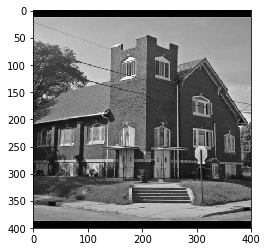

In [3]:
# Load image
img1 = load('https://pbs.twimg.com/profile_images/720317961085431808/4sv3BDNl_400x400.jpg')
img1 = rgb2gray(img1)
plt.imshow(img1, cmap='gray')
plt.show()

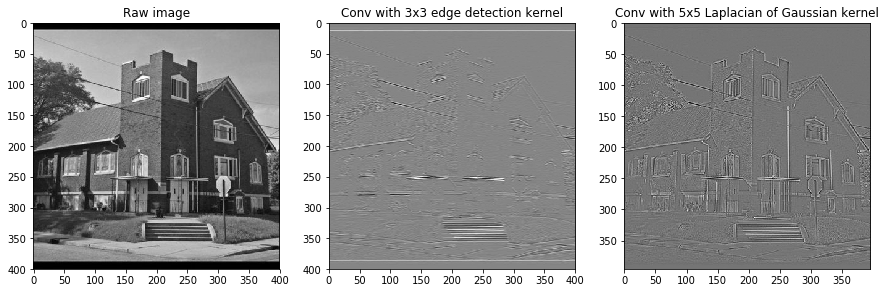

In [4]:
# Define two different convolution kernel here
my_kernel1 = torch.Tensor([[-1 ,-1, -1],[2, 2 ,2], [-1, -1 ,-1]])
my_kernel2 = torch.Tensor([[0 ,0, -1, 0, 0],[0, -1, -2, -1, 0],
                           [-1 ,-2, 16, -2, -1],[0, -1, -2, -1, 0],
                           [0 ,0, -1, 0, 0]])

# Calling this turns tensor into "weight" parameter
my_kernel1 = torch.nn.Parameter(my_kernel1.reshape(1, 1, 3, 3)) 
my_kernel2 = torch.nn.Parameter(my_kernel2.reshape(1, 1, 5, 5))                            

# Declare the Conv2d object for convolution operation
conv1 = torch.nn.Conv2d(in_channels=1,
                        out_channels=1,
                        kernel_size=3,
                        stride=1,
                        padding=1,
                        bias=True)

conv2 = torch.nn.Conv2d(in_channels=1,
                        out_channels=1,
                        kernel_size=5,
                        stride=1,
                        padding=0,
                        bias=True)

# Show the pre-initalized weight from Conv2d, you will see the bias in the initial kernel
#print('Pre-initalized weight', conv1.weight)

# Simply copying over the new weight 
conv1.weight = my_kernel1
conv2.weight = my_kernel2

height, width = img1.shape[0], img1.shape[1]

# Reshape the image that let it can be fit in the function input, and apply the operation on the image
img_conv1 = conv1(torch.from_numpy(img1.reshape(1, 1, height, width)).float())
img_conv2 = conv2(torch.from_numpy(img1.reshape(1, 1, height, width)).float())

# For plotting
plt.figure(1, figsize=(15, 6))
plt.subplot(131)
plt.imshow(img1, cmap='gray')
plt.title('Raw image')
plt.subplot(132)
plt.imshow(img_conv1[0][0].detach().numpy(), cmap='gray')
plt.title('Conv with 3x3 edge detection kernel')
plt.subplot(133)
plt.imshow(img_conv2[0][0].detach().numpy(), cmap='gray')
plt.title('Conv with 5x5 Laplacian of Gaussian kernel')

plt.show()

### Summary

Try to change the `padding` or `stride` in the declartion of Conv2d , you can see the results of different kernel parameter. In other words, you can say that different features would be extracted by different filter.

========================================================================

## Activation function

### Introduction
The activation layer controls how the signal flows from one layer to the next, emulating how neurons are fired in our brain. Output signals which are strongly associated with past references would activate more neurons, enabling signals to be propagated more efficiently for identification.

CNN is compatible with a wide variety of complex activation functions to model signal propagation, the most common function being the Rectified Linear Unit (ReLU), which is favored for its faster training speed.

### How does it works

There are some kind of activation function declared in `torch.nn.functional`.

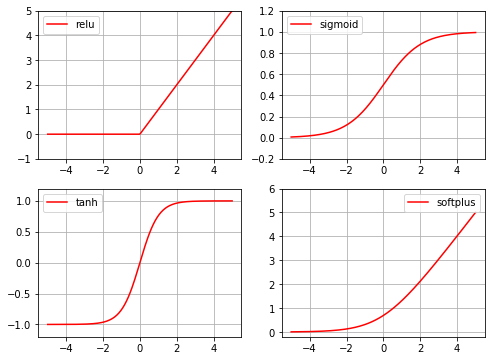

In [5]:
x = torch.linspace(-5, 5, 200)
x = Variable(x)

x_np = x.data.numpy()           # The reason why need to change data type to nparray is just for plotting

# A few of activations
y_relu = F.relu(x).data.numpy()
y_sigmoid = torch.sigmoid(x).data.numpy()
y_tanh = torch.tanh(x).data.numpy()
y_softplus = F.softplus(x).data.numpy()

# For plotting
plt.figure(1, figsize=(8, 6))
plt.subplot(221)
plt.plot(x_np, y_relu, c='red', label='relu')
plt.ylim((-1, 5))
plt.legend(loc='best')
plt.grid()

plt.subplot(222)
plt.plot(x_np, y_sigmoid, c='red', label='sigmoid')
plt.ylim((-0.2, 1.2))
plt.legend(loc='best')
plt.grid()

plt.subplot(223)
plt.plot(x_np, y_tanh, c='red', label='tanh')
plt.ylim((-1.2, 1.2))
plt.legend(loc='best')
plt.grid()

plt.subplot(224)
plt.plot(x_np, y_softplus, c='red', label='softplus')
plt.ylim((-0.2, 6))
plt.legend(loc='best')
plt.grid()

plt.show()


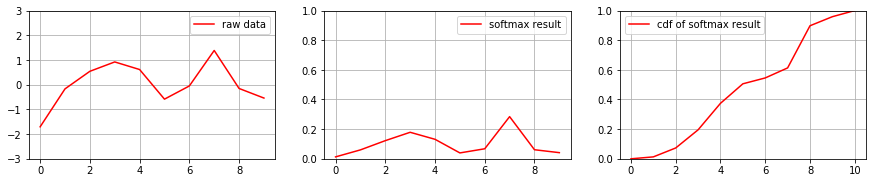

In [6]:
import random
# Softmax is also in torch.nn.functional
x = torch.randn(10) * 0.8
idx = random.randint(0, x.shape[0]-1)
x[idx] = x[idx] + abs(x[idx]) * 5
#print(x)


y_softmax = F.softmax(x, dim=0)


# Calculate the CDF of softmax result, you will see the sum of softmax result is equal to 1
y_cdf = torch.zeros(x.shape[0] + 1)
for i in range(1, x.shape[0] + 1):
    y_cdf[i] = y_cdf[i-1] + y_softmax[i-1]
#print(y_cdf)


plt.figure(1, figsize=(15, 6))
plt.subplot(231)
plt.plot(x.data.numpy() , c='red', label='raw data')
plt.ylim((-3, 3))
plt.legend(loc='best')
plt.grid()
plt.subplot(232)
plt.plot(y_softmax.data.numpy() , c='red', label='softmax result')
plt.ylim((0, 1))
plt.legend(loc='best')
plt.grid((-8, 0))
plt.subplot(233)
plt.plot(y_cdf.data.numpy() , c='red', label='cdf of softmax result')
plt.ylim((0, 1))
plt.legend(loc='best')
plt.grid()

plt.show()

### Summary

The softmax result work with functions that map to the unconstrained space of scores (x1,...,x𝑛), and then map those scores to the space of probability vectors in the last step.  This allows you to divide up the problem into 𝑛 subproblems of predicting 𝑦1,...,𝑦𝑛, and it's also a generalization of logistic regression.

======================================================================

## MaxPooling

### Introdution
It is common to periodically insert a Pooling layer in-between successive Conv layers in a ConvNet architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting.

### How does it work

There is an example that how to apply `MaxPool2d` operation on the image with Pytorch.


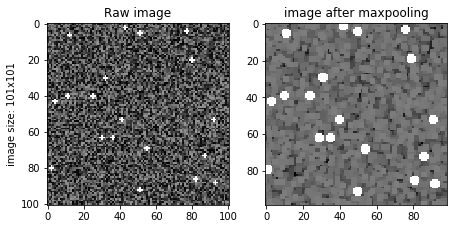

In [7]:
import random
# Generate a random image with specific size, and add some bright points as features
img2 = torch.rand(101, 101) * 0.6
for i in range(1,20):
    x = random.randint(0,img2.shape[0]-2)
    y = random.randint(0,img2.shape[1]-2)
    img2[x][y] = img2[x+1][y] = img2[x-1][y] = img2[x][y+1] = img2[x][y-1] = 1  

# Declare the MaxPool2d object for subsampling
maxpool = nn.MaxPool2d(kernel_size=3,
                       stride=1)

height2, width2 = img2.shape[0], img2.shape[1]


# Reshape the image and apply the MaxPool2d on the image
img_maxpool2 = maxpool(img2.reshape(1, 1, height2, width2))


# For plotting
plt.figure(1, figsize=(15, 6))
plt.subplot(141)
plt.imshow(img2, cmap='gray')
plt.title('Raw image')
plt.ylabel('image size: %dx%d' % (width2, height2))
plt.subplot(142)
plt.imshow(img_maxpool2[0][0], cmap='gray')
plt.title('image after maxpooling')
plt.show()

### Another maxpooling example

We apply the convolution(assume the kernel is for contour attraction), relu, and maxpooling on the image, to simulate a piece of the process for CNN.

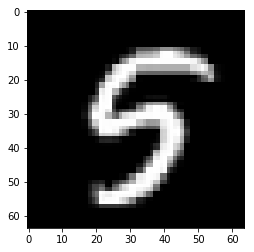

In [8]:
# Load image
img3 = load('http://bradleymitchell.me/wp-content/uploads/2014/06/decompressed.jpg', size=(64, 64))
plt.imshow(img3, cmap='gray')
plt.show()

torch.Size([1, 1, 60, 60])


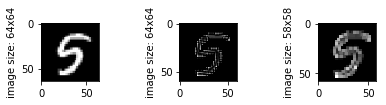

In [9]:
height3, width3 = img3.shape[0], img3.shape[1]

# Reshape the image and apply the convolution, relu and maxpooling on the image
img_conv3 = conv2(torch.from_numpy(img3.reshape(1, 1, height3, width3)).float())
img_relu3 = F.relu(img_conv3)
print(img_relu3.size())
img_maxpool3 = maxpool(img_relu3)

# For plotting
plt.ylabel('image size: %dx%d' % (img_maxpool2.shape[2], img_maxpool2.shape[3]))
plt.subplot(151)
plt.imshow(img3, cmap='gray')
plt.ylabel('image size: %dx%d' % (width3, height3))
plt.subplot(153)
plt.imshow(img_relu3[0][0].detach().numpy(), cmap='gray')
plt.ylabel('image size: %dx%d' % (width3, height3))
plt.subplot(155)
plt.imshow(img_maxpool3[0][0].detach().numpy(), cmap='gray')
plt.ylabel('image size: %dx%d' % (img_maxpool3.shape[2], img_maxpool3.shape[3]))

plt.show()

  ### Summary
  
  As you can see, the MaxPooling is a function like subsampling but not losing the own features of image . The are many method of subsampling but MaxPooling is the most popular.
  
  ========================================================================

## Reference:
    - act func ref:(https://morvanzhou.github.io/tutorials/machine-learning/torch/2-03-activation/-
    - cnn ref  : https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html
    - conv2 ref: https://discuss.pytorch.org/t/how-to-define-the-kernel-size-for-conv2d/21777/5
    - image ref: https://tev-static.fbk.eu/TeV/Technologies/TextInScene_files/I1.html
    